In [23]:

from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import xgboost as xgb
import gc
import sys
import os
sys.path.append(os.path.abspath("../../.."))


from Preprocessing.preprocessing_pipeline_impute import preprocessing_pipeline
from Preprocessing.imputation import get_imputation_maps, apply_imputation,ContextImputer
from Preprocessing.preprocessing_pipeline_segment import preprocessing_pipeline_segment
from Preprocessing.get_all_data import get_full_data
from Preprocessing.split_new import split_data
from utils.eval_call import evaluate_model
from utils.scatter_plot import scatter_prediction

MAE: 3949.79
RMSE: 15777.43
R²: 0.82


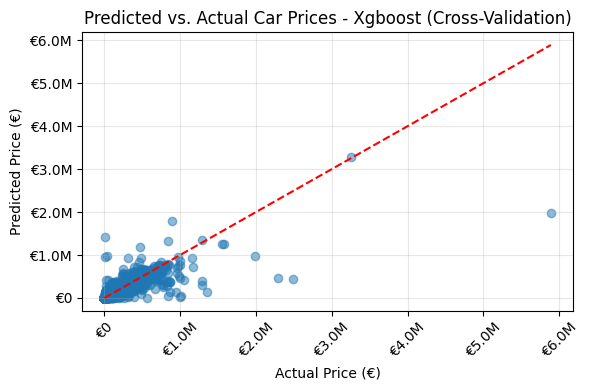

In [26]:
# lade die Daten - wichtig X und Y -> CV
X, y, categorical_features, numeric_features = get_full_data(segment = True) 


numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])
# Create Pipeline
xgb_pipeline = Pipeline([
    ('imp_fc', ContextImputer('fuel_consumption_l_100km')),
    ('imp_ps', ContextImputer('power_ps')),
    ('imp_er', ContextImputer('electric_range')),
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

# Cross Validation
kf = KFold(n_splits= 10, shuffle=True, random_state=42)
y_pred = cross_val_predict(xgb_pipeline, X, y, cv=kf)

# Evaluation
print("MAE:", round(mean_absolute_error(y, y_pred),2))
print("RMSE:", round(np.sqrt(mean_squared_error(y, y_pred)),2))
print("R²:", round(r2_score(y, y_pred),2))

scatter_prediction(y, y_pred, "Xgboost (Cross-Validation)")

### EDA

In [34]:
import pandas as pd
import seaborn as sns

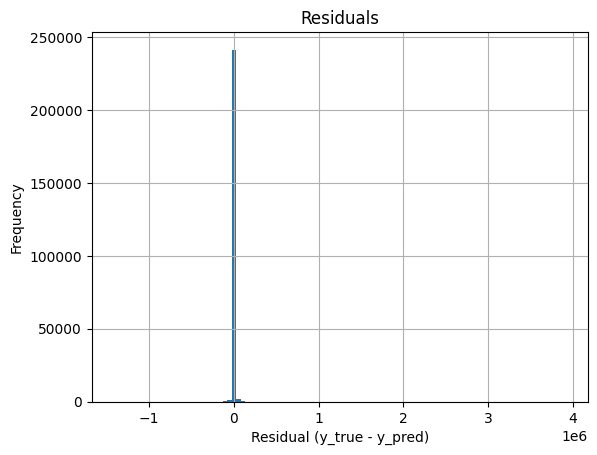

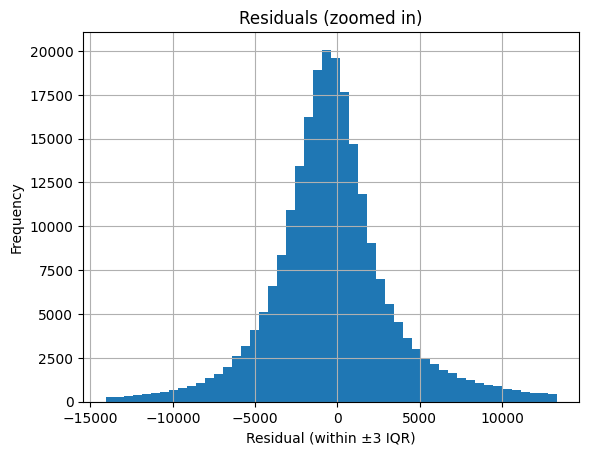

In [35]:
results = pd.DataFrame({
    'y_true': y,
    'y_pred': y_pred,
    'fuel'  : X['fuel_type'].values,
    'brand' : X['brand'].values,
    'model' : X['model'].values,
    'segment'  : X['segment'].values,
})

# Residuen berechnen
results['res'] = results['y_true'] - results['y_pred']

# Gesamte Residuen-Histogramm
results['res'].hist(bins=100)
plt.title('Residuals')
plt.xlabel('Residual (y_true - y_pred)')
plt.ylabel('Frequency')
plt.show()

# IQR-basierter Zoom (±3 * IQR)
q1, q3 = np.percentile(results['res'], [25, 75])
iqr = q3 - q1
mask = (results['res'] > q1 - 3 * iqr) & (results['res'] < q3 + 3 * iqr)

# Zoomed-in Residuen-Histogramm
results.loc[mask, 'res'].hist(bins=50)
plt.title("Residuals (zoomed in)")
plt.xlabel('Residual (within ±3 IQR)')
plt.ylabel('Frequency')
plt.show()

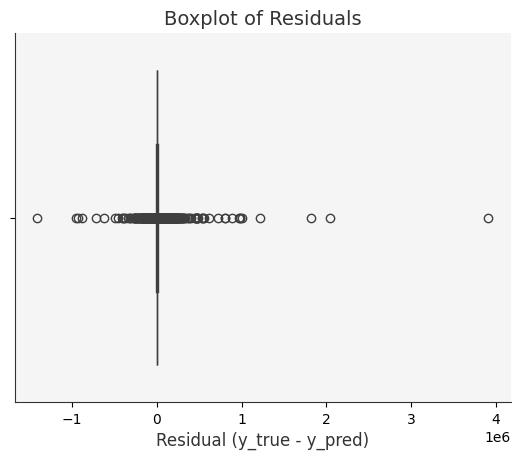

In [37]:
sns.boxplot(data=results, x = 'res')
plt.title("Boxplot der Residuen")
plt.xlabel("Residuum (y_true - y_pred)")
sns.despine()
plt.gca().patch.set_facecolor('#f5f5f5')
plt.gca().spines['bottom'].set_color('#333')
plt.gca().spines['left'].set_color('#333')
plt.xlabel("Residual (y_true - y_pred)", fontsize=12, color='#333')
plt.title("Boxplot of Residuals", fontsize=14, color='#333')
plt.show()